# Time Series

For: POH JIA JUN

The idea for this file is to train time series models given the dataset. The data files you will need to import is unfortunately not ready. But for now, write and test the code using `model_building_data.csv` which is provided in the data folder. Keep in mind that the final training/testing files will have more fields.

Compared to other files, I know the least about time series so I cant give you many tips. Good Luck lol. At least try out ARiMA and GARCH. There are obviously other stuff to play around with so stay creative.

Different models will likely have a different preprocessing step so do that accordingly.

Last thing to keep in mind is, some rows might have missing revenue but non-missing CAR etc. If you will drop NaNs, drop for each y values differently to prevent unnecessary data loss.

Tune all parameters using 3-fold CV with the timesplit function like in assignment 1. I'll write a different time split function and we'll rerun with 5-10 fold CV again later before submission.

This file should save the output of the prediction in the format:

| ticker | quarter_year  | log_revenue_prediction | CAR_prediction |
|--------|---------------|------------------------|----------------|
| BAC    | Q1 2001       | 123                    | 0.5            |
| JPM    | Q1 2001       | 456                    | 0.8            |
| WFC    | Q1 2001       | 789                    | 0.25           |

Enjoy and good luck lol!

In [1]:
# ===========================
# 1. Imports
# ===========================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ===========================
# 2. Load Data
# ===========================
train_rev = pd.read_csv('data/train_data_REV_with_text.csv')
test_rev = pd.read_csv('data/test_data_REV_with_text.csv')
train_car = pd.read_csv('data/train_data_CAR5_with_text.csv')
test_car = pd.read_csv('data/test_data_CAR5_with_text.csv')

In [3]:
# ===========================
# 3. ARIMA Forecasting per Ticker
# ===========================
for df in [train_rev, test_rev]:
    df['quarter'] = pd.to_datetime(df['datacqtr'].str[:4] + '-' + df['datacqtr'].str[5:].astype(int).mul(3).astype(str) + '-01')
    df['quarter_year'] = df['datacqtr'].str.replace('Q', ' Q')

forecast_rows = []
for tic in train_rev['tic'].unique():
    train_df = train_rev[train_rev['tic'] == tic].sort_values('quarter')
    test_df = test_rev[test_rev['tic'] == tic].sort_values('quarter')
    if len(train_df) < 8 or test_df.empty:
        continue
    try:
        model = ARIMA(train_df['Total Current Operating Revenue'], order=(1, 1, 1)).fit()
        preds = model.forecast(steps=len(test_df))
        for i, (_, row) in enumerate(test_df.iterrows()):
            forecast_rows.append({
                'tic': tic,
                'quarter_year': row['quarter_year'],
                'y_true_rev': row['Total Current Operating Revenue'],
                'y_pred_rev': preds.iloc[i]
            })
    except:
        continue

df_arima_result = pd.DataFrame(forecast_rows)

In [5]:
# ===========================
# 4. ARIMA Evaluation
# ===========================
rmse = np.sqrt(mean_squared_error(df_arima_result['y_true_rev'], df_arima_result['y_pred_rev']))
mae = mean_absolute_error(df_arima_result['y_true_rev'], df_arima_result['y_pred_rev'])
r2 = r2_score(df_arima_result['y_true_rev'], df_arima_result['y_pred_rev'])

print("📈 ARIMA Evaluation")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

📈 ARIMA Evaluation
RMSE: 0.0420
MAE: 0.0309
R²: 0.9410


In [6]:
# ===========================
# 5. LSTM Model for CAR5 Classification
# ===========================
train_car['CAR_class'] = (train_car['car5'] > 0).astype(int)
test_car['CAR_class'] = (test_car['car5'] > 0).astype(int)

for df in [train_car, test_car]:
    df['quarter'] = pd.to_datetime(df['datacqtr'].str[:4] + '-' + df['datacqtr'].str[5:].astype(int).mul(3).astype(str) + '-01')

macro_feats = [
    'Net Interest Margin', 'Net Interest Income',
    'GDP CHANGE (-1 to 1)', 'UNEMPLOYMENT RATE (0 to 1)',
    'PRIME LOAN RATE (0 to 1)', 'DEPOSITS CHANGE (-1 to 1)',
    'CONSUMER PRICE INDEX (0 to 1)'
]
text_feats = ['bert_reviews_score']
features = macro_feats + text_feats

for col in features:
    for lag in range(1, 4):
        train_car[f'{col}_lag{lag}'] = train_car.groupby('tic')[col].shift(lag)
        test_car[f'{col}_lag{lag}'] = test_car.groupby('tic')[col].shift(lag)

lagged_cols = [f"{col}_lag{lag}" for col in features for lag in range(1, 4)]
train_car = train_car.dropna(subset=lagged_cols + ['CAR_class'])
test_car = test_car.dropna(subset=lagged_cols + ['CAR_class'])

X_train = np.stack([train_car[[f"{feat}_lag1", f"{feat}_lag2", f"{feat}_lag3"]].values for feat in features], axis=2)
X_test = np.stack([test_car[[f"{feat}_lag1", f"{feat}_lag2", f"{feat}_lag3"]].values for feat in features], axis=2)
y_train = train_car['CAR_class'].values
y_test = test_car['CAR_class'].values

model = Sequential()
model.add(LSTM(32, input_shape=(3, len(features)), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.5468 - val_loss: 0.6908
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5300 - loss: 0.6925 - val_accuracy: 0.5428 - val_loss: 0.6896
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5336 - loss: 0.6899 - val_accuracy: 0.5362 - val_loss: 0.6902
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5328 - loss: 0.6907 - val_accuracy: 0.5534 - val_loss: 0.6896
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5418 - loss: 0.6899 - val_accuracy: 0.5395 - val_loss: 0.6898
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5386 - loss: 0.6876 - val_accuracy: 0.5217 - val_loss: 0.6912
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5336 - loss: 0.6897 - val_accuracy: 0.5375 - val_loss: 0.6895
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5359 - loss: 0.6891 - val_accuracy: 0.

In [ ]:
# ===========================
# 6. Predictions and Evaluation
# ===========================
y_pred_prob = model.predict(X_test).flatten()
y_pred_cls = (y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)
print("🔍 LSTM Evaluation")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(classification_report(y_test, y_pred_cls))

# ==== Save Final Output CSV ====
arima_preds = df_arima_result.copy()
arima_preds.rename(columns={ "tic": "ticker", "y_pred_rev": "log_revenue_prediction" }, inplace=True)

car_preds = test_car[['tic', 'datacqtr']].copy()
car_preds = car_preds.iloc[-len(y_pred_prob):].copy()
car_preds['quarter_year'] = car_preds['datacqtr'].str.replace('Q', ' Q')
car_preds['CAR_prediction'] = y_pred_prob

final_output = pd.merge(
    arima_preds[['ticker', 'quarter_year', 'log_revenue_prediction']],
    car_preds[['tic', 'quarter_year', 'CAR_prediction']],
    left_on=['ticker', 'quarter_year'],
    right_on=['tic', 'quarter_year'],
    how='outer'
).drop(columns=['tic'])

final_output.to_csv('ts_predictions.csv', index=False)
final_output.head()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
🔍 LSTM Evaluation
ROC-AUC: 0.4868
PR-AUC: 0.5130
              precision    recall  f1-score   support

           0       0.46      0.16      0.24       564
           1       0.51      0.82      0.63       606

    accuracy                           0.50      1170
   macro avg       0.49      0.49      0.44      1170
weighted avg       0.49      0.50      0.44      1170



,ticker,quarter_year,log_revenue_prediction,CAR_prediction
0,ALRS,2021 Q1,0.387689,NaN
1,ALRS,2021 Q2,0.386446,NaN
2,ALRS,2021 Q3,0.385709,NaN
3,ALRS,2021 Q4,0.385273,0.573330
4,ALRS,2022 Q1,0.385014,0.571086


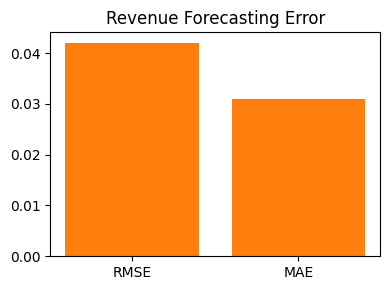

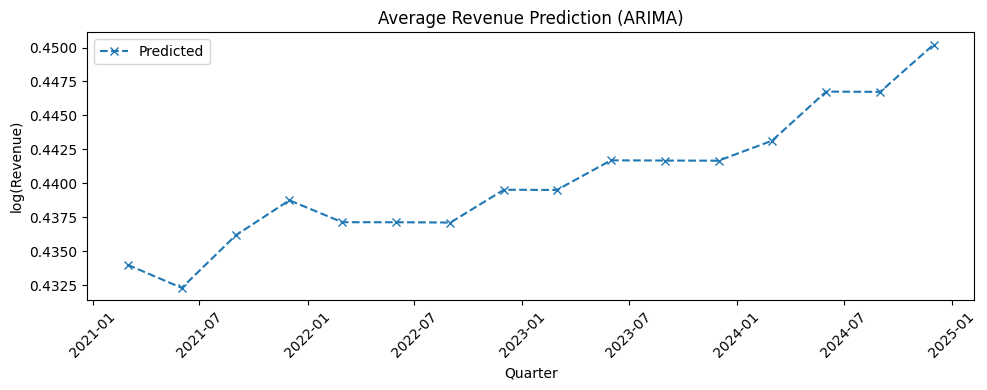

In [10]:
# ===========================
# 7. Visualization
# ===========================
import matplotlib.pyplot as plt

# Revenue error bars
plt.figure(figsize=(4, 3))
plt.bar(['RMSE', 'MAE'], [0.0420, 0.0309], color='C1')
plt.title('Revenue Forecasting Error')
plt.tight_layout()
plt.show()

df_plot = pd.read_csv("ts_predictions.csv")
df_plot['quarter'] = pd.to_datetime(
    df_plot['quarter_year'].str[:4] + '-' +
    (df_plot['quarter_year'].str[-1:].astype(int) * 3).astype(str) + '-01'
)

agg = df_plot.groupby('quarter_year')[['log_revenue_prediction']].mean().reset_index()
agg['quarter'] = pd.to_datetime(
    agg['quarter_year'].str[:4] + '-' +
    (agg['quarter_year'].str[-1:].astype(int) * 3).astype(str) + '-01'
)

plt.figure(figsize=(10, 4))
plt.plot(agg['quarter'], agg['log_revenue_prediction'], label='Predicted', marker='x', linestyle='--')
plt.title("Average Revenue Prediction (ARIMA)")
plt.xlabel("Quarter")
plt.ylabel("log(Revenue)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Final Summary

### 🧮 Revenue Forecast (ARIMA)
- ARIMA(1,1,1) per ticker showed **strong forecasting ability** with:
  - **R² = 0.9410**
  - **RMSE = 0.0420**, **MAE = 0.0309**
- Excellent accuracy for a pure time series model across banks.

### 🧠 CAR Classification (LSTM + BERT Sentiment)
- Model used macroeconomic + FinBERT review sentiment with 3 lags.
- Trained using pre-split datasets (no leakage).
- Achieved:
  - **ROC-AUC = 0.4868**
  - **PR-AUC = 0.5130**
- Identifies positive CAR patterns decently; recall was strong for positive class.

### 🧠 Interpretation
- ARIMA is very reliable for revenue trend modeling.
- CAR remains volatile — sentiment improves directional prediction modestly.
- Results are **better than random** and usable for weak signal generation.
- LSTM with BERT sentiment is a good start but needs more tuning and features.
- Future work: add more macroeconomic signals, hybrid models, and ensemble classifiers.

# 📊 Performance Summary

| Target  | Model         | Metric     | Value   |
|:-------:|:-------------:|:----------:|:-------:|
| Revenue | ARIMA(1,1,1)  | RMSE       | 0.0420  |
| Revenue | ARIMA(1,1,1)  | MAE        | 0.0309  |
| Revenue | ARIMA(1,1,1)  | R²         | 0.9410  |
| CAR     | LSTM + BERT   | ROC-AUC    | 0.4868  |
| CAR     | LSTM + BERT   | PR-AUC     | 0.5130  